In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import datac as dt
# import model_4_o as md
import model_ResUGAN as md
import copy
from pytorch_ssim import ssim
from pytorch_edgeloss import EDGE
from pytorch_ssim import msssim
from torch.utils.data import DataLoader
import csvgenerator as csvg
from torch.autograd import Variable
# e/d + i
# best mode so far

In [2]:
# print gpu
torch.cuda.set_device(7)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 7
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:7')
else:
    device = "cpu"
print(device)

cuda:7


In [4]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = csvg.get_csv_path(True)
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(128),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 128, 128]) torch.Size([32, 128, 128])
1 torch.Size([32, 3, 128, 128]) torch.Size([32, 128, 128])
2 torch.Size([32, 3, 128, 128]) torch.Size([32, 128, 128])
3 torch.Size([32, 3, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


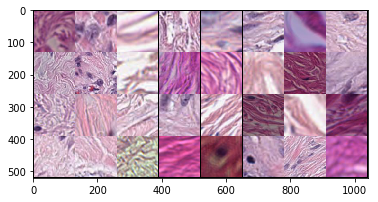

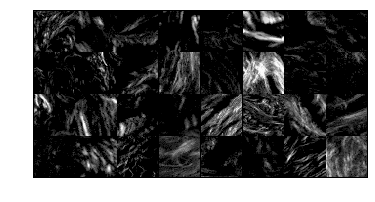

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.GeneratorUNet()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))


===> Building model


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)
#     wanna loss < 0.06

In [22]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
            
            imgs_input = Variable(input.type(Tensor))
            prediction = model(imgs_input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           
            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()
    
            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
#             targetf = target[:, None]
            
#             lossMSE = criterionMSE(prediction, targetf)      
#             lossSSIM = -ssim(prediction, targetf)
        
#             p = 0.25
#             loss = p*lossMSE + (1-p)*lossSSIM
#             combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
# #             mse = criterion(prediction, target.float())

#             psnr = 10 * torch.log10(1 / loss)
#             avg_psnr += psnr
            if iteration == 16:
                break
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

In [ ]:
test()

In [ ]:
l = 0.0001
p = 0.5
windowsize = 3
for epoch in range(1, 18 + 1):
    if epoch%2 == 0:
        windowsize = windowsize+1
        p = p*0.8
        l = l*0.2
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

In [18]:
edge = EDGE()
criterionL1L = nn.L1Loss()
Tensor = torch.cuda.FloatTensor
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        imgs_input = Variable(input.type(Tensor))
        output = model(imgs_input)
        targetf = target.float()
        targetf = targetf[:, None]
        
#         lossMSE = criterionMSE(output, targetf)
        lossL1 = criterionL1L(output, targetf)
#         lossL1 = edge(output, targetf)
        lossSSIM = 1-msssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossL1 + (1-p)*lossSSIM
        combineLoss = p*lossL1.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossL1: " + str(lossL1.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

In [ ]:
test()

In [ ]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'encoderresinfo.pth')
torch.save(model.state_dict(), path)

In [ ]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'encoderresinfo.pth')
model = md.Net()
model.load_state_dict(torch.load(path))
model.eval()
torch.cuda.empty_cache()
model.to(device)

In [ ]:
test()

In [16]:
l = 0.0001
p = 0.85
windowsize = 11
for epoch in range(1, 20 + 1):
#     if epoch%5 == 0:
#         windowsize = windowsize+1
#         p = p*1
#         l = l*0.2
#         if windowsize >= 20:
#             windowsze = 20
    optimizer = optim.Adam(model.parameters(), lr=l, betas=(0.5, 0.999))
        
    train(epoch, p, windowsize)

lossL1: 0.10786532610654831 lossSSIM: 0.9767180681228638
===> Epoch[1](0/6083): Loss: 0.2382
lossL1: 0.09452862292528152 lossSSIM: 0.9169030785560608
===> Epoch[1](50/6083): Loss: 0.2179
lossL1: 0.09144970029592514 lossSSIM: 0.9439417123794556
===> Epoch[1](100/6083): Loss: 0.2193
lossL1: 0.10971046984195709 lossSSIM: 0.9380905032157898
===> Epoch[1](150/6083): Loss: 0.2340
lossL1: 0.13086755573749542 lossSSIM: 0.9720644950866699
===> Epoch[1](200/6083): Loss: 0.2570
lossL1: 0.11950477957725525 lossSSIM: 0.965888261795044
===> Epoch[1](250/6083): Loss: 0.2465
lossL1: 0.12704695761203766 lossSSIM: 0.9772911071777344
===> Epoch[1](300/6083): Loss: 0.2546
lossL1: 0.10302925109863281 lossSSIM: 0.9267215728759766
===> Epoch[1](350/6083): Loss: 0.2266
lossL1: 0.08490931987762451 lossSSIM: 0.9418307542800903
===> Epoch[1](400/6083): Loss: 0.2134
lossL1: 0.11013687402009964 lossSSIM: 0.947634756565094
===> Epoch[1](450/6083): Loss: 0.2358
lossL1: 0.12822914123535156 lossSSIM: 0.972080111503601

KeyboardInterrupt: 

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


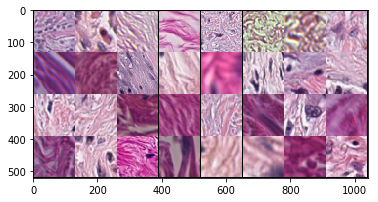

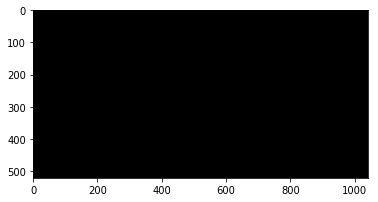

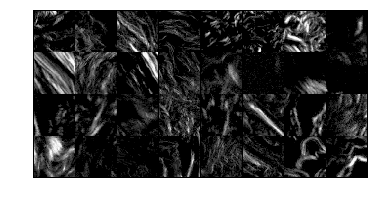

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


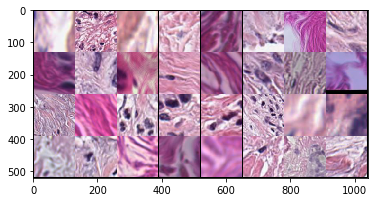

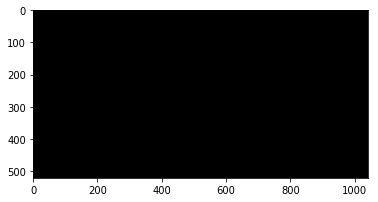

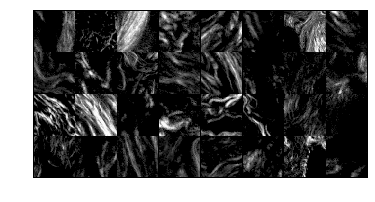

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


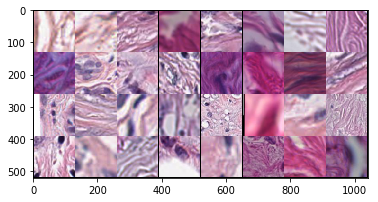

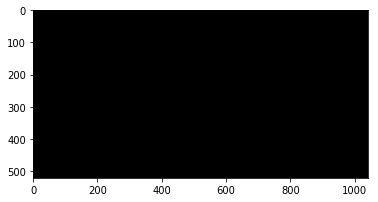

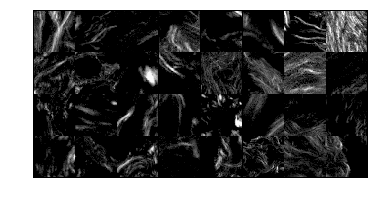

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


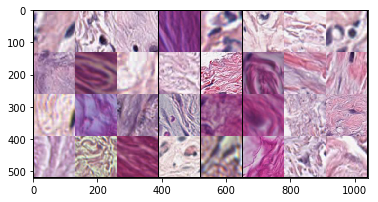

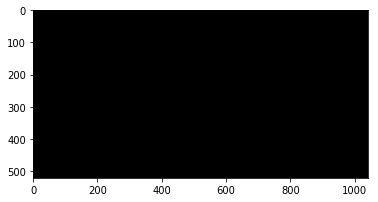

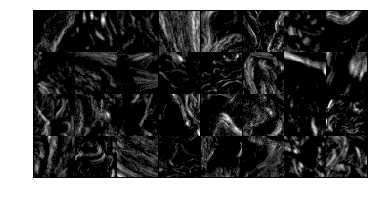

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


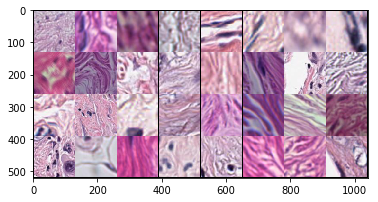

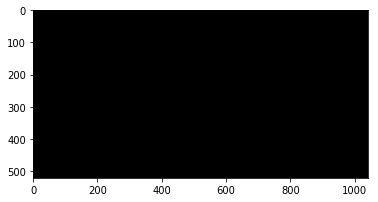

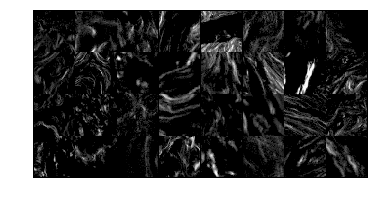

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


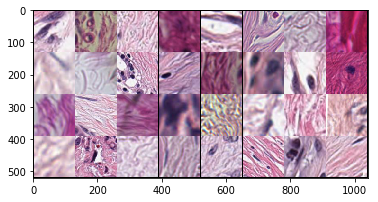

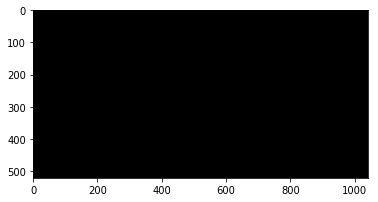

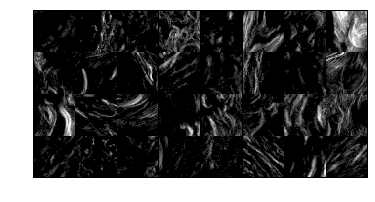

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


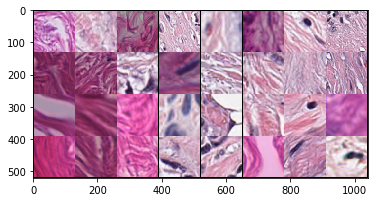

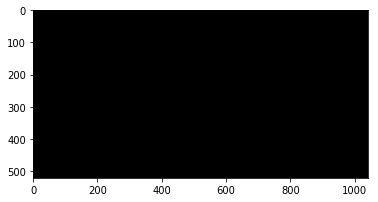

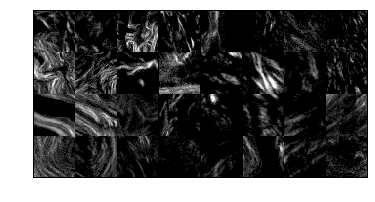

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


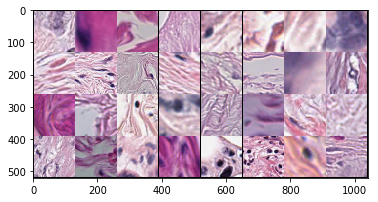

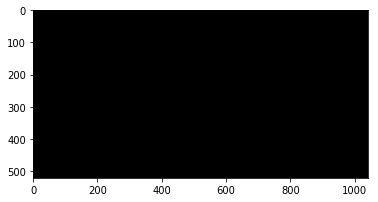

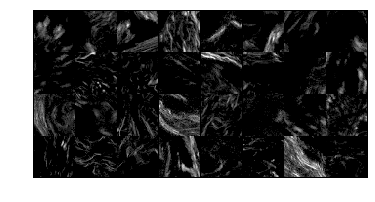

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


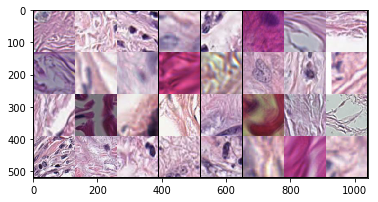

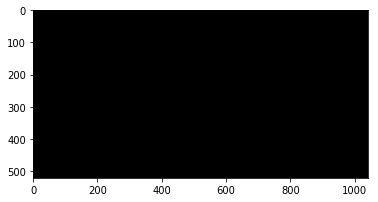

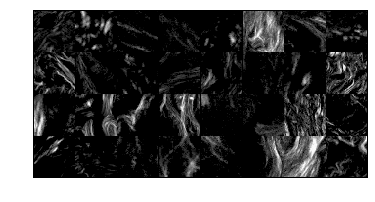

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


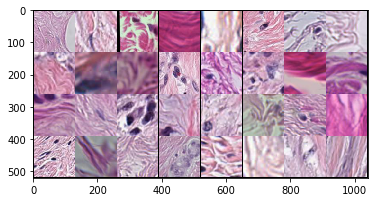

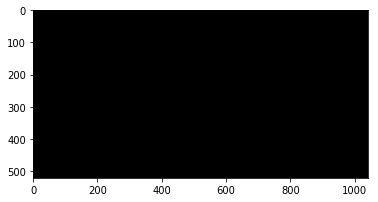

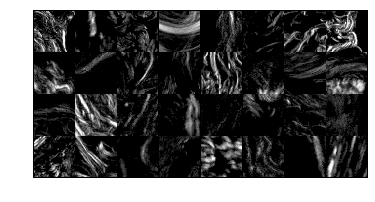

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


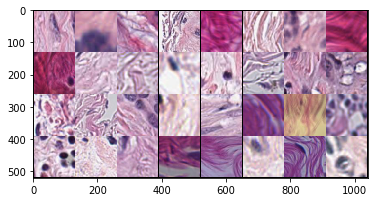

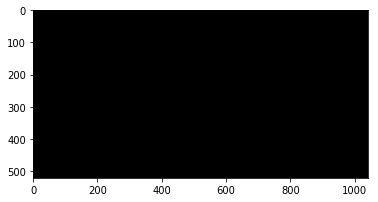

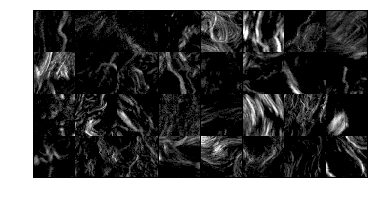

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


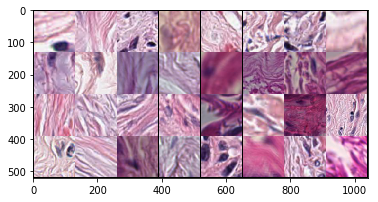

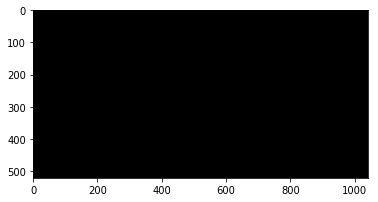

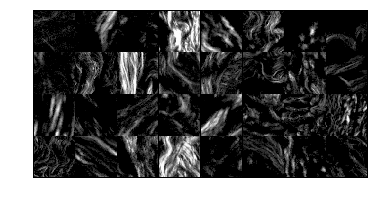

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


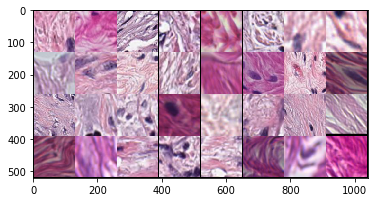

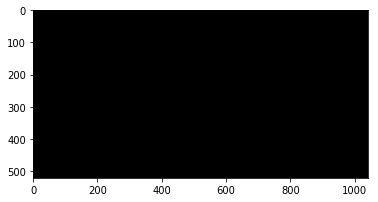

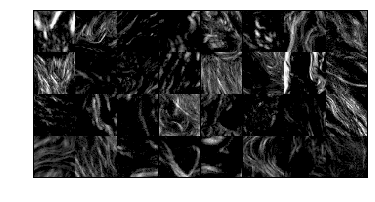

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


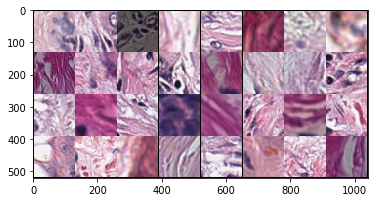

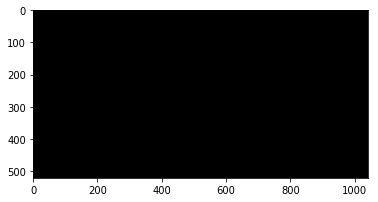

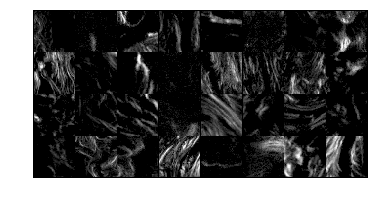

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


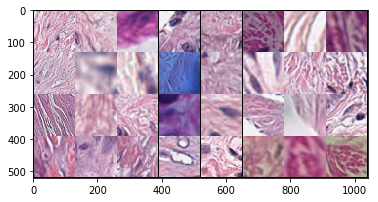

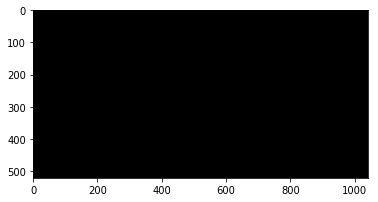

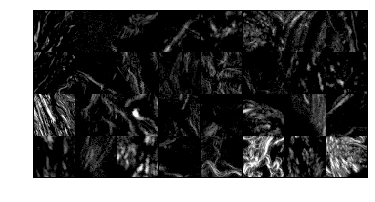

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


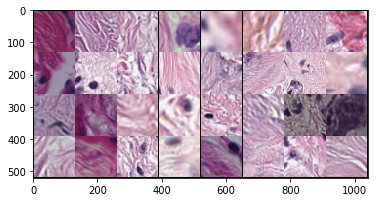

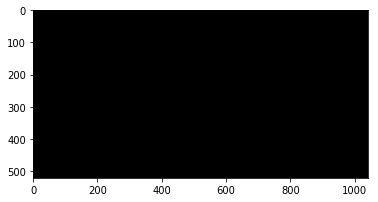

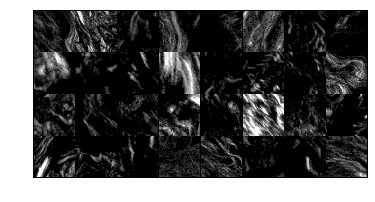

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])
torch.Size([32, 1, 128, 128])


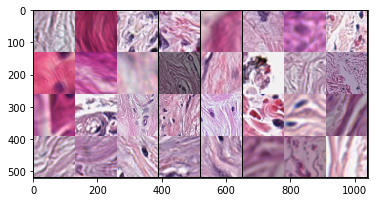

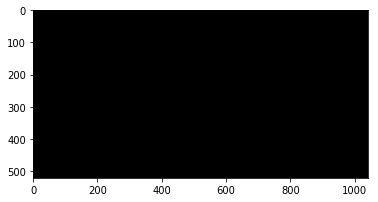

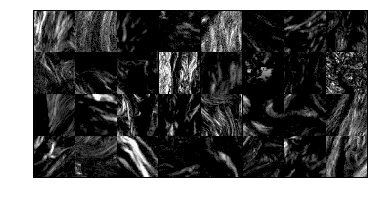

In [23]:
test()